<a href="https://colab.research.google.com/github/Pipickin/Tensorflow/blob/main/Images/Augmentation_Example/FullCatsVsDogs_and_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [ ]:
# Download zip file with required images

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-10-03 15:15:32--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 92.123.124.137, 2a02:26f0:6b:5a5::e59, 2a02:26f0:6b:5b3::e59
Connecting to download.microsoft.com (download.microsoft.com)|92.123.124.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   145MB/s    in 5.7s    

2020-10-03 15:15:38 (139 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [ ]:
os.listdir('/tmp')

['readme[1].txt', 'cats-and-dogs.zip', 'PetImages', 'MSR-LA - 3467.docx']

In [ ]:
# Create the directories cats-v-dogs and subdirectories for training and testing
# These in turn will need subdirectories for 'cats' and 'dogs'
try:
    tmp_path = '/tmp/cats-v-dogs/'
    tmp_path_train = tmp_path+'training/'
    tmp_path_test = tmp_path+'testing/'

    os.mkdir(tmp_path)
    os.mkdir(tmp_path_train)
    os.mkdir(tmp_path_test)

    for folder in ['cats/', 'dogs/']:
      os.mkdir(tmp_path_train + folder)
      os.mkdir(tmp_path_test + folder)
except OSError:
    pass

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  fnames = []

  for name_image in os.listdir(SOURCE):
    path_data = SOURCE + name_image
    if os.path.getsize(path_data)>0:
      fnames.append(name_image)
    else:
      print(name_image + 'is zero length, so ignoring')

  train_size = int(len(fnames)*SPLIT_SIZE)
  test_size = int(len(fnames)-train_size)

  shuffled_fnames = random.sample(fnames, len(fnames))
  train_fnames = shuffled_fnames[:train_size]
  test_fnames = shuffled_fnames[-test_size:]

  for train_fname in train_fnames:
    copyfile(SOURCE+train_fname,TRAINING+train_fname)

  for test_fname in test_fnames:
    copyfile(SOURCE+test_fname,TESTING+test_fname)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpgis zero length, so ignoring
11702.jpgis zero length, so ignoring


In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [ ]:
# Let's create a simple model
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),input_shape=(150,150,3), activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 165888)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               84935168  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 84,940,769
Trainable params: 84,940,769
Non-trainable params: 0
____________________________________________

In [ ]:
# Use ImageDataGenerator to rescale our images and convert the images to batches for the model
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    target_size=(150,150),
                                                    class_mode = 'binary',
                                                    batch_size=10)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing' 
validation_datagen = ImageDataGenerator(rescale=1/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              target_size=(150,150),
                                                              class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    steps_per_epoch = 2248,
                    validation_steps = 250)

Epoch 1/15
1083/2248 [=============>................] - ETA: 1:29 - loss: 0.7241 - accuracy: 0.6431

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2248/2248 [==============================] - 182s 81ms/step - loss: 0.6593 - accuracy: 0.6699 - val_loss: 0.5514 - val_accuracy: 0.7196
Epoch 2/15
2248/2248 [==============================] - 182s 81ms/step - loss: 0.5316 - accuracy: 0.7483 - val_loss: 0.5782 - val_accuracy: 0.7044
Epoch 3/15
2248/2248 [==============================] - 182s 81ms/step - loss: 0.4821 - accuracy: 0.7863 - val_loss: 0.5728 - val_accuracy: 0.7624
Epoch 4/15
2248/2248 [==============================] - 182s 81ms/step - loss: 0.4460 - accuracy: 0.8120 - val_loss: 0.5852 - val_accuracy: 0.7432
Epoch 5/15
2248/2248 [==============================] - 182s 81ms/step - loss: 0.4052 - accuracy: 0.8335 - val_loss: 0.5416 - val_accuracy: 0.7392
Epoch 6/15
2248/2248 [==============================] - 181s 81ms/step - loss: 0.3666 - accuracy: 0.8574 - val_loss: 0.7223 - val_accuracy: 0.7444
Epoch 7/15
2248/2248 [==============================] - 181s 81ms/step - loss: 0.3325 - accuracy: 0.8749 - val_loss: 1.2508 - val

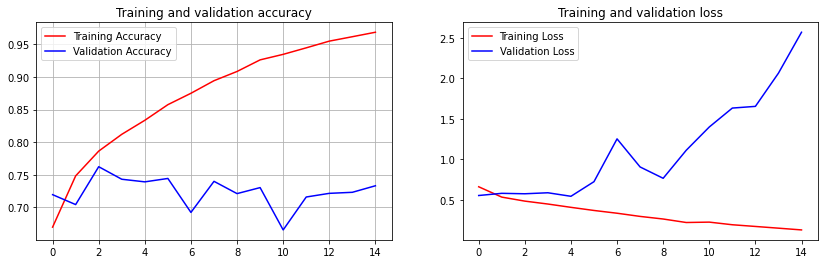

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# Let's write function to plot train's/test's accuracy and loss
def plot_acc_and_loss(history):

  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc))

  figures,axes = plt.subplots(1,2, figsize = (14,4))

  axes[0].plot(epochs, acc, 'r', label = "Training Accuracy")
  axes[0].plot(epochs, val_acc, 'b', label = "Validation Accuracy")
  axes[0].set_title('Training and validation accuracy')
  axes[0].legend()
  axes[0].grid()

  axes[1].plot(epochs, loss, 'r', label = "Training Loss")
  axes[1].plot(epochs, val_loss, 'b', label = "Validation Loss")
  axes[1].set_title('Training and validation loss')
  axes[1].legend()

plot_acc_and_loss(history)

In [ ]:
# Now, we improve the model. Adding some convolution's layers will help our model to detect more difficult relation
more_dif_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),input_shape=(150,150,3), activation='relu'),
                                             tf.keras.layers.Conv2D(16,(3,3), activation = 'relu'),
                                             tf.keras.layers.MaxPool2D((2,2)),
                                             tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
                                             tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
                                             tf.keras.layers.MaxPool2D((2,2)),
                                             tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                             tf.keras.layers.Flatten(),
                                             tf.keras.layers.Dense(512, activation='relu'),
                                             tf.keras.layers.Dense(1, activation='sigmoid')
                                             ])

more_dif_model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
more_dif_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)       

In [ ]:
history_of_more_dif = more_dif_model.fit(train_generator,
                                         epochs=15,
                                         verbose=1,
                                         validation_data=validation_generator,
                                         steps_per_epoch = 2248,
                                         validation_steps = 250)

Epoch 1/15
1130/2248 [==============>...............] - ETA: 44s - loss: 0.6530 - accuracy: 0.6448

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2248/2248 [==============================] - 96s 43ms/step - loss: 0.6029 - accuracy: 0.6842 - val_loss: 0.4878 - val_accuracy: 0.7608
Epoch 2/15
2248/2248 [==============================] - 92s 41ms/step - loss: 0.4898 - accuracy: 0.7757 - val_loss: 0.5138 - val_accuracy: 0.7636
Epoch 3/15
2248/2248 [==============================] - 90s 40ms/step - loss: 0.4491 - accuracy: 0.8012 - val_loss: 0.4266 - val_accuracy: 0.8092
Epoch 4/15
2248/2248 [==============================] - 91s 40ms/step - loss: 0.4270 - accuracy: 0.8156 - val_loss: 0.4993 - val_accuracy: 0.8212
Epoch 5/15
2248/2248 [==============================] - 92s 41ms/step - loss: 0.4124 - accuracy: 0.8290 - val_loss: 0.4850 - val_accuracy: 0.7744
Epoch 6/15
2248/2248 [==============================] - 93s 41ms/step - loss: 0.3976 - accuracy: 0.8369 - val_loss: 0.3760 - val_accuracy: 0.8400
Epoch 7/15
2248/2248 [==============================] - 92s 41ms/step - loss: 0.3843 - accuracy: 0.8455 - val_loss: 1.2413 - val_accura

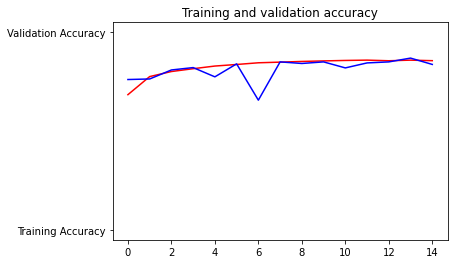

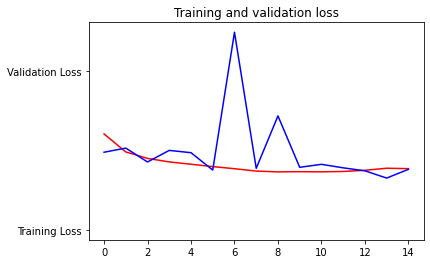

In [ ]:
plot_acc_and_loss(history_of_more_dif)

In [ ]:
# Now we will use data augmentation to avoid overfitting, but let's look at the result.
train_datagen_with_augmentation = ImageDataGenerator(rescale=1/255.,
                                                     zoom_range=0.2,
                                                     horizontal_flip=True,
                                                     rotation_range=45,
                                                     width_shift_range=0.2,
                                                     height_shift_range=0.2,
                                                     shear_range=0.2)

train_generator_with_augmentation = train_datagen_with_augmentation.flow_from_directory(TRAINING_DIR,
                                                                                        target_size=(150,150),
                                                                                        class_mode = 'binary',
                                                                                        batch_size=10)

history_of_model_with_augmentation = model.fit(train_generator_with_augmentation,
                                               epochs=15,
                                               verbose=1,
                                               validation_data=validation_generator,
                                               steps_per_epoch = 2248,
                                               validation_steps = 250)

Found 22498 images belonging to 2 classes.
Epoch 1/15
1615/2248 [====================>.........] - ETA: 54s - loss: 0.6934 - accuracy: 0.6146

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2248/2248 [==============================] - 201s 89ms/step - loss: 0.6841 - accuracy: 0.6229 - val_loss: 0.5670 - val_accuracy: 0.7188
Epoch 2/15
2248/2248 [==============================] - 201s 90ms/step - loss: 0.6539 - accuracy: 0.6537 - val_loss: 0.5594 - val_accuracy: 0.7124
Epoch 3/15
2248/2248 [==============================] - 204s 91ms/step - loss: 0.6866 - accuracy: 0.6686 - val_loss: 0.5376 - val_accuracy: 0.7396
Epoch 4/15
2248/2248 [==============================] - 205s 91ms/step - loss: 0.6235 - accuracy: 0.6728 - val_loss: 0.5823 - val_accuracy: 0.7128
Epoch 5/15
2248/2248 [==============================] - 204s 91ms/step - loss: 0.6210 - accuracy: 0.6800 - val_loss: 0.5478 - val_accuracy: 0.7232
Epoch 6/15
2248/2248 [==============================] - 205s 91ms/step - loss: 0.6108 - accuracy: 0.6901 - val_loss: 0.5340 - val_accuracy: 0.7292
Epoch 7/15
2248/2248 [==============================] - 208s 92ms/step - loss: 0.6101 - accuracy: 0.6923 - val_loss: 0.5411 - val

As you can see our model perfomces worse result than even the simple model. It's can be if validation data has the same data as the train data, but after augmentation the train data has been changed and our model can't generalize.